## LSTM

In [9]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
from sklearn.model_selection import  RandomizedSearchCV
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import tensorflow.keras as keras
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import asarray
from numpy import zeros
import fasttext ###
from keras.regularizers import L2

### Dataset Loading and Splitting

In [12]:
df_train = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/train_tweets_LSTM_no_new.csv')
df_val = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/eval_tweets_LSTM_no_new.csv')
df_test = pd.read_csv('../../data/New dataset/LSTM/no_preprocessing/test_tweets_LSTM_no_new.csv')

In [15]:
X_train, y_train = df_train["tweet_text"], df_train["cyberbullying_type"]
X_val, y_val = df_val["tweet_text"], df_val["cyberbullying_type"]
X_test, y_test = df_test["tweet_text"], df_test["cyberbullying_type"]

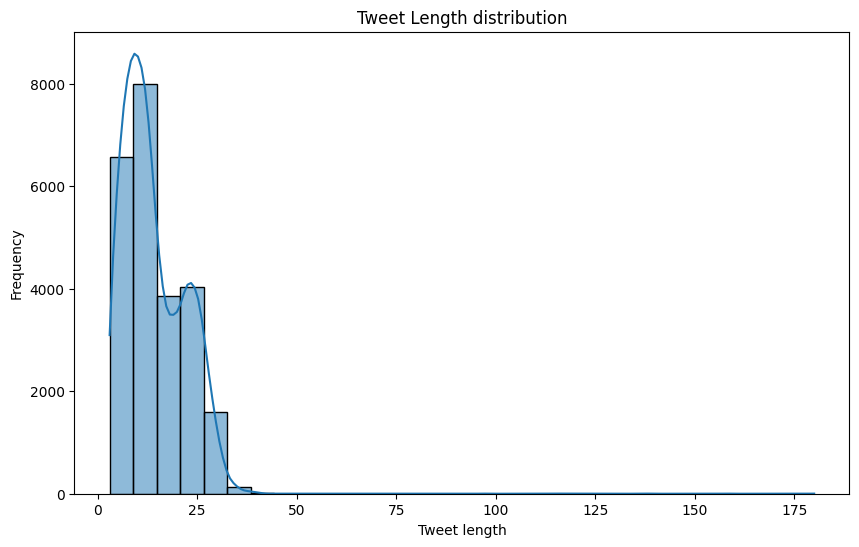

In [16]:
df_train['tweet_length'] = df_train['tweet_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df_train['tweet_length'], bins=30, kde=True)
plt.title('Tweet Length distribution')
plt.xlabel('Tweet length')
plt.ylabel('Frequency')
plt.show()

In [17]:
df_train['text_len'] = [len(text.split()) for text in df_train.tweet_text]
max_len = 45
count = (df_train['text_len'] >= max_len).sum() 
total_tweets = len(df_train)
percentage = (count / total_tweets) * 100
print(f"Percentage of tweets longer than {max_len} tokens: {percentage:.2f}%")

Percentage of tweets longer than 45 tokens: 0.04%


### Embeddings

In [18]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform label encoder on the target variable
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

#Each word in input used as a key, while a unique index is used as the value of the key 
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)
X_val = word_tokenizer.texts_to_sequences(X_val)

vocab_length = len(word_tokenizer.word_index) + 1

print("The vocaboulary length is:", vocab_length)

X_train = pad_sequences(X_train, padding = 'pre', maxlen = max_len)
X_test = pad_sequences(X_test, padding = 'pre', maxlen = max_len)
X_val = pad_sequences(X_val, padding = 'pre', maxlen = max_len)


The vocaboulary length is: 31783


#### Glove

In [22]:
# Load GloVe word embeddings and create a dictionary that willl contain words as keys, and their corresponging embedding list as values. 

embeddings_dictionary = dict()
glove_file = open('Embeddings/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:

    records = line.split()
    word = records[0]

    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_length, 200)) ## change if the dimention of embedding changes above

i = 0
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)

    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        i = i + 1

print("The number of out-of-vocabulary words is:", i)
print("The percentage of out-of-vocabulary words is:", (i/vocab_length) * 100 )

The number of out-of-vocabulary words is: 6683
The percentage of out-of-vocabulary words is: 21.026964100305197


#### Fasttext

In [21]:
# Load FastText model
ft_model = fasttext.load_model('/Users/chiarapiccolo/Desktop/HTL_prove/fasttext.model')
embedding_dim = 100
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding = ft_model.get_word_vector(word)
    if embedding is not None:
        embedding_matrix[index] = ft_model.get_word_vector(word)
    else:
        print("Something is not working")
        break

### Model Creation and RandomizedGridSearch

In [23]:
# Just checking everything is working properly

print(X_train[1])
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   13   12   23  198    1   33   38 6774  942  471
  142 2469 3947]
X_train shape: (24183, 45)
y_train shape: (24183,)
X_val shape: (6106, 45)
y_val shape: (6106,)
X_test shape: (7519, 45)
y_test shape: (7519,)


In [24]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_length, 
                        output_dim=embedding_matrix.shape[1], 
                        weights=[embedding_matrix],  
                        trainable=False, # Depending on which embeddings we use
                        mask_zero = True))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Choice('units', values=[16, 32, 64], kernel_regularizer=L2(0.01))))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

In [25]:
# RandomSearch configuration
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=2,  # Max numbers of different configurations to test
    executions_per_trial=1,  # Number of times each config is executed (different weigths initialization)
    overwrite=True,
    directory='random_search10',
    project_name='rs_keras_tuner_demo4'
)

# Callback di EarlyStopping
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

fixed_batch_size = 64
tuner.search(X_train, y_train, 
             epochs=50, 
             validation_data=(X_val, y_val),
             callbacks=[callback],
             batch_size=fixed_batch_size)

Trial 2 Complete [00h 06m 11s]
val_loss: 0.2121308594942093

Best val_loss So Far: 0.2121308594942093
Total elapsed time: 00h 12m 35s


In [26]:
# Check the results of the search 

num_trials = len(tuner.oracle.trials)
print(f'Number of evaluated configurations: {num_trials}')

tuner.results_summary()

Number of evaluated configurations: 2
Results summary
Results in random_search10/rs_keras_tuner_demo4
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 1 summary
Hyperparameters:
dropout_1: 0.5
units: 16
dropout_2: 0.30000000000000004
Score: 0.2121308594942093

Trial 0 summary
Hyperparameters:
dropout_1: 0.5
units: 64
dropout_2: 0.4
Score: 0.2156846672296524


### Model Training

As suggested on the Keras official documentation, we retrain the model using the best parameters found. 

In [27]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hp.
model = build_model(best_hps[0])

# Model training
history = model.fit(x = X_train, y = y_train, 
                         epochs=50,
                         validation_data = [X_val, y_val],
                         callbacks = [callback],
                         batch_size=fixed_batch_size)

Epoch 1/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - acc: 0.5437 - loss: 1.1197 - val_acc: 0.8675 - val_loss: 0.3982
Epoch 2/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - acc: 0.8588 - loss: 0.4258 - val_acc: 0.8929 - val_loss: 0.3404
Epoch 3/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - acc: 0.8819 - loss: 0.3595 - val_acc: 0.9060 - val_loss: 0.2884
Epoch 4/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - acc: 0.8955 - loss: 0.3134 - val_acc: 0.9070 - val_loss: 0.2766
Epoch 5/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - acc: 0.8997 - loss: 0.2998 - val_acc: 0.9111 - val_loss: 0.2757
Epoch 6/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - acc: 0.8994 - loss: 0.2944 - val_acc: 0.9101 - val_loss: 0.2763
Epoch 7/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - acc: 0.9040 - loss: 0.2818 - val_acc: 0.9170 - val_loss: 0.2491
Epoch 8/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - acc: 0.9066 - loss: 0.2782 - val_acc: 0.9178 - val_loss: 0.2443
Epoch 9/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms

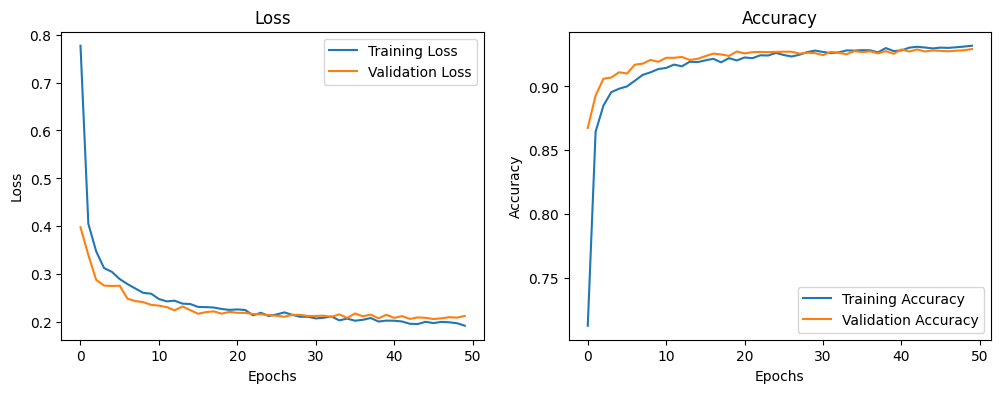

In [28]:
# Loss and accuracy plots for training and validation

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Model Assessment

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9391 - loss: 0.1891
Test Loss: 0.20013350248336792
Test Accuracy: 0.933900773525238


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1568
           1       0.98      0.98      0.98      1502
           2       0.93      0.87      0.90      1497
           3       0.80      0.89      0.84      1338
           4       0.96      0.96      0.96      1614

    accuracy                           0.93      7519
   macro avg       0.93      0.93      0.93      7519
weighted avg       0.94      0.93      0.93      7519

Class Names:  ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'religion']


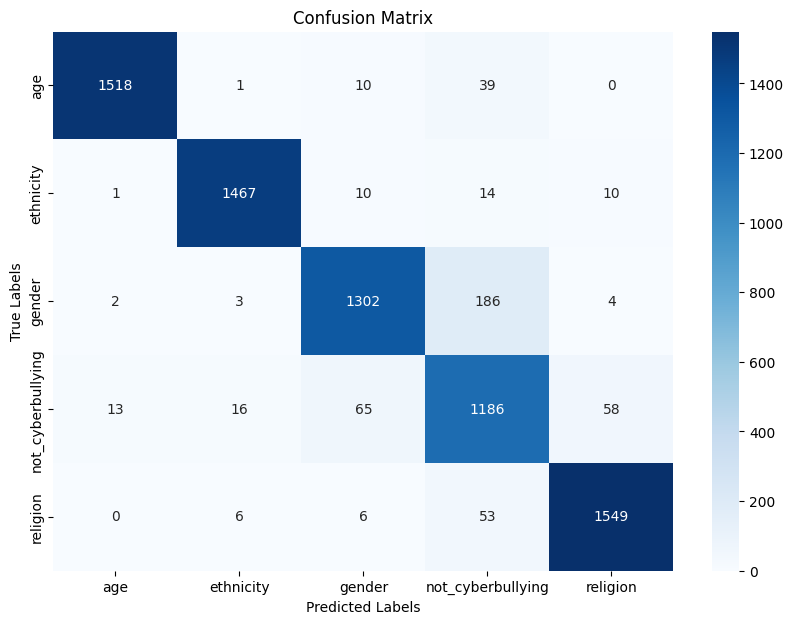

In [30]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

class_names = label_encoder.classes_
print("Class Names: ", class_names)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()